# 训练部分附图

## 研究区位图

### Load data (for sampling)

In [4]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from function.global_varibles import PATHS
from function import *
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')


gogogo
[OK] TensorFlow available
[OK] scikeras available
[OK] SHAP available
You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值


### Helper function for plot

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

def _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv):
    """设置坐标轴和经纬度网格"""
    # 设置数据框线
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color('black')

    # 经纬度刻度
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # 绘制网格线和设置刻度
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)


def _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线
    xticks, xlabels = [], []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        p = _choose_point_on_edge(line.intersection(bottom))
        if p is None:
            p = _choose_point_on_edge(line.intersection(top))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 2%的图宽
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                xlabels.append(f"{abs(int(round(lon)))}°W")

        if i <= len(lon_ticks) :
            ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 纬度网格线（刻度不显示）
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 刻度不显示
    ax.xaxis.set_major_locator(mticker.NullLocator())
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_locator(mticker.NullLocator())
    ax.yaxis.set_major_formatter(mticker.NullFormatter())
    ax.tick_params(axis='both', labelsize=5, pad=1, length=0)



def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

### 绘图函数

弃光面积统计: 最小值=0.00 ha, 最大值=515459.22 ha
分位数边界: [  4842.57554868  31649.44167715  64815.69337036 100516.81501499
 184895.73195452]
开始聚合embedding点，总数: 10152
地理区划聚合结果: 312个区划
包含embedding点的区划数: 236
Embedding点数量分布: 最小0.0, 最大1113.0
气泡分类统计:
  >1000点: 3个区划 (深绿色, 80)
  800-1000点: 0个区划 (绿色, 60)
  100-800点: 18个区划 (浅绿色, 40)
  50-100点: 13个区划 (浅蓝色, 25)
  10-50点: 63个区划 (蓝色, 15)
  <10点: 215个区划（不绘制）
Embedding点聚合完成: 原始10152个点 → 312个地理区划


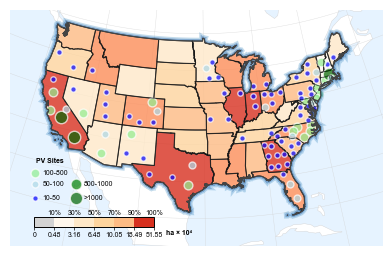

In [20]:
def plot_smaplesites_nature_style(
    df_abandon_filtered, 
    us_counties_4326, 
    df_pv_embedding,
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    参数:
        df_abandon_filtered: DataFrame，包含要绘制的撂荒点，必须包含'lat'、'lon'和'area_m2'列
        us_counties_4326: GeoDataFrame，美国各县边界
        df_pv_embedding: DataFrame，包含要绘制的embedding数据，必须包含'lat'和'lon'列
        add_north_arrow_and_scalebar: bool, 是否添加指北针和比例尺
        add_embedding_points: bool, 是否绘制embedding点

        按照county聚合df_abandon_filtered的面积，然后以分位数划分绘制
        以气泡聚合的形式绘制df_pv_embedding的点
    """
    
    # ==================== 1. 初始设置 ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 创建图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(100/25.4, 60/25.4))
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理县界数据
    us_counties_bound = us_counties_4326.to_crs(epsg=4326).clip(bbox)
    us_counties_albers = us_counties_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_counties_albers.total_bounds

    # 边界调整
    margin_x_left = (xmax - xmin) * 0.08   # 增大左边界
    margin_x_right = (xmax - xmin) * 0.02  # 减小右边界
    margin_y = (ymax - ymin) * 0.08

    # 在ymin留更多空给color bar
    colorbar_space = (ymax - ymin) * 0.08  
    xmin = xmin - margin_x_left
    xmax = xmax + margin_x_right
    ymin = ymin - margin_y * 1 - colorbar_space
    ymax = ymax + margin_y * 0.8

    # 画布比例调整
    fig_width, fig_height = fig.get_size_inches()
    aspect_ratio = fig_width / fig_height
    data_width = xmax - xmin
    data_height = ymax - ymin
    data_aspect = data_width / data_height
    
    if data_aspect > aspect_ratio:
        # 数据过宽，调整y范围，保持中心
        center_y = (ymin + ymax) / 2
        new_height = data_width / aspect_ratio
        ymin = center_y - new_height / 2
        ymax = center_y + new_height / 2
        # 适度放大y范围，避免边界裁切
        ymin *= 1.05
        ymax *= 1.05
    else:
        # 数据偏高，调整x范围，保持中心
        center_x = (xmin + xmax) / 2
        new_width = data_height * aspect_ratio
        xmin = center_x - new_width / 2
        xmax = center_x + new_width / 2
        # 适度收缩x范围，突出主体
        xmin *= 0.9
        xmax *= 1

    # 设置坐标轴位置和范围
    ax.set_position([0.0, 0.08, 1, 0.87])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制县界
    us_counties_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 6. 坐标轴设置 ====================
    _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 7. 背景地图 ====================
    _draw_background_map(ax, usa_bounds_main)

    # ==================== 8. 数据可视化 ====================
    # 绘制df_abandon_filtered的面积在county上的聚合
    # 1. 先将弃光点转为GeoDataFrame
    gdf_abandon = gpd.GeoDataFrame(
        df_abandon_filtered,
        geometry=gpd.points_from_xy(df_abandon_filtered['lon'], df_abandon_filtered['lat']),
        crs='EPSG:4326'
    )
    # 2. 投影到Albers
    gdf_abandon = gdf_abandon.to_crs('ESRI:102003')
    # 3. 空间连接到county，统计每个county的弃光面积总和
    county_abandon_area = gpd.sjoin(
        gdf_abandon, us_counties_albers, how='left', predicate='within'
    ).groupby('index_right')['area_m2'].sum()
    # 4. 合并回county GeoDataFrame
    us_counties_albers['abandon_area_ha'] = county_abandon_area / 10000  # 转换为公顷
    us_counties_albers['abandon_area_ha'] = us_counties_albers['abandon_area_ha'].fillna(0)

    # 5. 绘制底图（county边界，弃光面积用分位数划分）
    # 计算分位数边界
    area_values = us_counties_albers['abandon_area_ha'].values
    area_quantiles = np.percentile(area_values[area_values > 0], [10, 30, 50, 70, 90])  # 排除0值计算分位数
    
    # 创建分位数分类
    def classify_area(area):
        if area == 0:
            return 0  # 无弃光
        elif area <= area_quantiles[0]:
            return 1  # 0-10%分位数
        elif area <= area_quantiles[1]:
            return 2  # 20-40%分位数
        elif area <= area_quantiles[2]:
            return 3  # 40-60%分位数
        elif area <= area_quantiles[3]:
            return 4  # 60-80%分位数
        elif area <= area_quantiles[4]:
            return 5  # 80-95%分位数
        else:
            return 6  # 95-100%分位数
    
    us_counties_albers['area_class'] = us_counties_albers['abandon_area_ha'].apply(classify_area)
    
    print(f"弃光面积统计: 最小值={area_values.min():.2f} ha, 最大值={area_values.max():.2f} ha")
    print(f"分位数边界: {area_quantiles}")
    
    # 创建自定义颜色映射：灰色到YlOrRd
    colors = ['#D3D3D3', '#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#d7301f']
    custom_cmap = ListedColormap(colors)
    
    # 绘制county聚合的弃光面积
    plot_result = us_counties_albers.plot(
        ax=ax,
        column='area_class',
        cmap=custom_cmap,
        linewidth=0.8,
        edgecolor='#333333',
        alpha=0.8,
        zorder=2,
        legend=False
    )

    # 6. 绘制embedding点（气泡聚合）
    legend_bubbles = []
    if add_embedding_points and (df_pv_embedding is not None):
        print(f"开始聚合embedding点，总数: {len(df_pv_embedding)}")
        
        # 使用us_argscv_4326的地理区划进行聚合
        # 1. 先将embedding点转为GeoDataFrame
        gdf_embedding = gpd.GeoDataFrame(
            df_pv_embedding,
            geometry=gpd.points_from_xy(df_pv_embedding['lon'], df_pv_embedding['lat']),
            crs='EPSG:4326'
        )
        
        # 2. 投影到Albers
        gdf_embedding = gdf_embedding.to_crs('ESRI:102003')
        
        # 3. 空间连接到地理区划，统计每个区划内的点数
        us_argscv_albers = us_argscv_4326.to_crs('ESRI:102003')
        district_embedding_count = gpd.sjoin(
            gdf_embedding, us_argscv_albers, how='left', predicate='within'
        ).groupby('index_right').size()
        us_argscv_albers['embedding_count'] = district_embedding_count
        us_argscv_albers['embedding_count'] = us_argscv_albers['embedding_count'].fillna(0)
        
        print(f"地理区划聚合结果: {len(us_argscv_albers)}个区划")
        print(f"包含embedding点的区划数: {(us_argscv_albers['embedding_count'] > 0).sum()}")
        print(f"Embedding点数量分布: 最小{us_argscv_albers['embedding_count'].min()}, 最大{us_argscv_albers['embedding_count'].max()}")
        
        # 5. 根据区划内点数分类并设置气泡大小和颜色（调整为更合理的大小）
        def classify_district_size(count):
            if count > 1000:
                return 80, 'darkgreen', '>1000'      # 从500调整为80
            elif count > 800:
                return 60, 'green', '800-1000'       # 从350调整为60
            elif count > 100:
                return 40, 'lightgreen', '100-800'   # 从200调整为40
            elif count > 50:
                return 25, 'lightblue', '50-100'     # 从120调整为25
            elif count > 10:
                return 15, 'blue', '10-50'           # 从60调整为15
            else:
                return 0, 'none', None
        
        # 6. 绘制气泡
        for idx, row in us_argscv_albers.iterrows():
            count = row['embedding_count']
            if count > 10:
                center = row.geometry.centroid
                center_x, center_y = center.x, center.y
                bubble_size, bubble_color, bubble_label = classify_district_size(count)
                if bubble_label and bubble_label not in [b[2] for b in legend_bubbles]:
                    legend_bubbles.append((bubble_size, bubble_color, bubble_label))
                    ax.scatter(
                        center_x, center_y,
                        s=bubble_size,
                        c=bubble_color,
                        marker='o',
                        alpha=0.7,
                        edgecolors='white',
                        linewidth=1.0,
                        zorder=6,
                        label=bubble_label
                    )
                else:
                    ax.scatter(
                        center_x, center_y,
                        s=bubble_size,
                        c=bubble_color,
                        marker='o',
                        alpha=0.7,
                        edgecolors='white',
                        linewidth=1.0,
                        zorder=6
                    )
        
        # 统计各类气泡的数量
        district_sizes = us_argscv_albers['embedding_count'].values
        large_districts = np.sum(district_sizes > 1000)
        medium_large_districts = np.sum((district_sizes > 800) & (district_sizes <= 1000))
        medium_districts = np.sum((district_sizes > 100) & (district_sizes <= 800))
        medium_small_districts = np.sum((district_sizes > 50) & (district_sizes <= 100))
        small_districts = np.sum((district_sizes > 10) & (district_sizes <= 50))
        
        print(f"气泡分类统计:")
        print(f"  >1000点: {large_districts}个区划 (深绿色, 80)")
        print(f"  800-1000点: {medium_large_districts}个区划 (绿色, 60)")
        print(f"  100-800点: {medium_districts}个区划 (浅绿色, 40)")
        print(f"  50-100点: {medium_small_districts}个区划 (浅蓝色, 25)")
        print(f"  10-50点: {small_districts}个区划 (蓝色, 15)")
        print(f"  <10点: {np.sum(district_sizes <= 10)}个区划（不绘制）")
        
        print(f"Embedding点聚合完成: 原始{len(df_pv_embedding)}个点 → {len(us_argscv_albers)}个地理区划")

    # ==================== 9. 颜色条 ====================
    _add_colorbar_sites(fig, ax, custom_cmap, area_values, area_quantiles)

    # ==================== 10. 气泡图例 ====================
    if add_embedding_points and (df_pv_embedding is not None):
        _add_bubble_legend(fig, ax)

    fig.canvas.draw()
    
    ax.set_position([0.0, 0.0, 1, 1]) 

    return fig, ax


def _add_colorbar_sites(fig, ax, custom_cmap, area_values, area_quantiles):
    """添加颜色条 - 参照plot_single_variable_nature_style的风格"""
    def add_horizontal_cbar_sites(fig, ax, mappable, var_bins, unit_display=None):
        pos = ax.get_position()
        left = pos.x0 + 0 * pos.width
        bottom = pos.y0 + 0 * pos.height
        width = 0.37 * pos.width
        height = 0.05 * pos.height

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(5)  # 进一步降低zorder
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks([0, 1, 2, 3, 4, 5, 6])

        # 格式化刻度标签 
        area_labels = []
        area_labels.append('0')
        area_labels.append(f'{area_quantiles[0]/10000:.2f}')
        area_labels.append(f'{area_quantiles[1]/10000:.2f}')
        area_labels.append(f'{area_quantiles[2]/10000:.2f}')
        area_labels.append(f'{area_quantiles[3]/10000:.2f}')
        area_labels.append(f'{area_quantiles[4]/10000:.2f}')
        area_labels.append(f'{area_values.max()/10000:.2f}')
        cb.set_ticklabels(area_labels)

        # 细长
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)

        # 百分位标签（去掉最外层的0%和100%）
        percentile_labels = ['10%', '30%', '50%', '70%', '90%', '100%']  # 只保留中间的分位数
        major_tick_locs = cb.get_ticks()[1:]  # 只去掉首，不去掉尾
        for loc, label in zip(major_tick_locs, percentile_labels):
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.1, label, transform=cax.transAxes,
                    ha='center', va='bottom', fontsize=5, clip_on=False)

        # 移除clip_path设置，避免截断其他元素
        # for ch in cax.get_children():
        #     try:
        #         ch.set_clip_path(cax.patch)
        #     except Exception:
        #         pass

        return cax, cb

    # 创建ScalarMappable用于colorbar
    from matplotlib.cm import ScalarMappable
    norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6], custom_cmap.N)
    sm = ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])

    cbar_ax, cbar = add_horizontal_cbar_sites(fig, ax, sm, [0, 1, 2, 3, 4, 5, 6], "ha")
    cbar_ax.text(1.1, -0.3, "ha × 10⁴", ha='left', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)


def _add_bubble_legend(fig, ax):
    """添加气泡图例（调整气泡大小为更合理的大小）"""
    # 在colorbar上方添加embedding点的图例
    legend_ax = inset_axes(ax, width="20%", height="32%",
                          loc='lower left',
                          bbox_to_anchor=(0.02, 0.16, 1, 1),
                          bbox_transform=ax.transAxes, borderpad=1)
    legend_ax.set_xlim(-0.05, 1.05)
    legend_ax.set_ylim(-0.05, 1.05)
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    
    for spine in legend_ax.spines.values():
        spine.set_visible(False)
    legend_ax.set_facecolor('none')
    legend_ax.set_zorder(20)  # 提高zorder，确保在colorbar之上
    
    # 图例项参数（调整为更合理的大小）
    legend_items = [
        # (size, color, label, x, y)
        (40, 'lightgreen', '100-800', 0.05, 0.28),
        (25, 'lightblue', '50-100', 0.05, 0.14),
        (15, 'blue', '10-50', 0.05, -0.05),
        (60, 'green', '800-1000', 0.6, 0.14),
        (80, 'darkgreen', '>1000', 0.6, -0.05),
    ]
    
    for size, color, label, x, y in legend_items:
        legend_ax.scatter(x, y, s=size, c=color, marker='o', alpha=0.7,
                         edgecolors='white', linewidth=1.0, zorder=25, transform=legend_ax.transAxes,clip_on=False)
        legend_ax.text(x+0.10, y, label, ha='left', va='center', fontsize=5, color='black',
                      fontweight='normal', transform=legend_ax.transAxes, zorder=25)
    
    # 添加图例标题
    legend_ax.text(0.25, 0.45, "PV Sites", ha='center', va='center', fontsize=5, 
                  fontweight='bold', transform=legend_ax.transAxes, zorder=25)


def _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv):
    """设置坐标轴和经纬度网格（去掉外框线）"""
    # 去掉外框线
    for spine in ax.spines.values():
        spine.set_visible(False)

    # 经纬度刻度
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # 绘制网格线和设置刻度
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)
import os

fig, ax = plot_smaplesites_nature_style(
    df_abandon_filtered, 
    us_states_4326, 
    df_embedding,
    add_north_arrow_and_scalebar=False,
    add_embedding_points=True
)

output_dir = os.path.join('figure', 'US_figure', 'US_workflow')
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, 'sample_sites.png'), dpi=300, format='png')
fig.savefig(os.path.join(output_dir, 'sample_sites.pdf'), dpi=300, format='pdf')




## 特征提取图

### Extract data from ds

In [2]:
from function import load_all_ds_emission, load_all_ds

ds_carbon=load_all_ds_emission()
ds_feat=load_all_ds()
output_dir = r'D:\xarray\us_aligned'



gogogo


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anacon

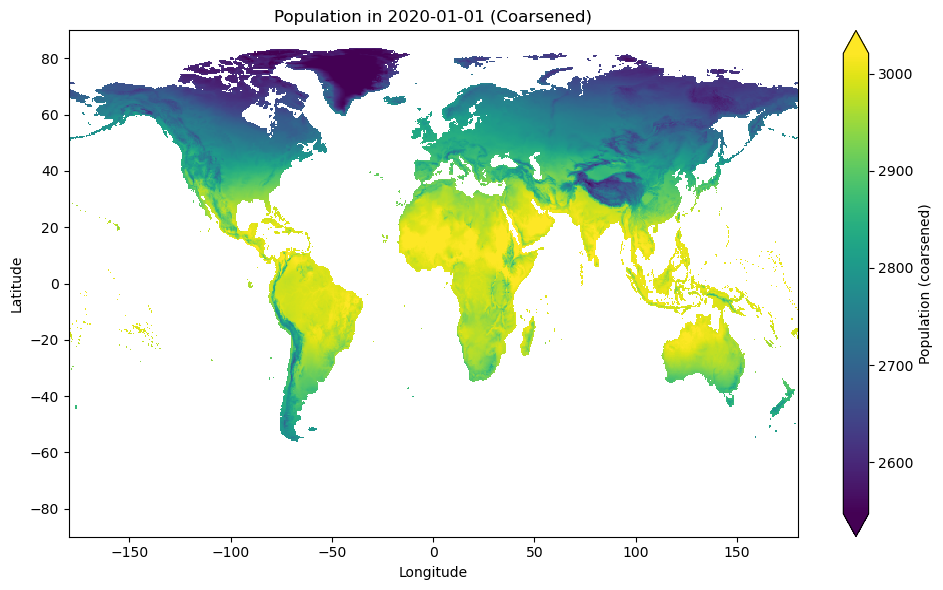

In [3]:
import matplotlib.pyplot as plt

# Select the Population data for 2020-01-01
pop_2020 = ds_feat['tas'].sel(time='2020-01-01')

# Coarsen the data for faster/lower-res plotting (e.g., by factor of 5 in both dims)
pop_2020_coarse = pop_2020.coarsen(lat=50, lon=50, boundary='trim').mean()

# Plot the coarsened data
plt.figure(figsize=(10, 6))
pop_2020_coarse.plot(
    cmap='viridis',
    robust=True,
    cbar_kwargs={'label': 'Population (coarsened)'}
)
plt.title('Population in 2020-01-01 (Coarsened)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [4]:
import rasterio
from rasterio.features import geometry_mask
import affine
import geopandas as gpd
from shapely.geometry import mapping,box
import xarray as xr



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')






### Plot each variable 

In [7]:
# ==== 必要库导入 ====
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap, LogNorm
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator, ScalarFormatter, MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import box, mapping, LineString
from pyproj import Transformer
import xarray as xr
import geopandas as gpd
import matplotlib.patches as mpatches

# ==== 分类图例样式：1~9 类 ====
LANDCOVER_LABELS = {
    1: "Cropland",
    2: "Forest",
    3: "Savanna",
    4: "Shrub",
    5: "Grassland and Arid Ecosystem",
    6: "Wetland",
    7: "Built-up",
    8: "Bare Area and Ice",
    9: "Water",
}
# 颜色尽量色盲友好 & 区分度高
LANDCOVER_COLORS = {
    1: "#FFD24D",  # Cropland
    2: "#2CA25F",  # Forest
    3: "#A1D76A",  # Savanna
    4: "#8C6D31",  # Shrub
    5: "#F1E2A1",  # Grassland & Arid
    6: "#2CB1B1",  # Wetland (teal)
    7: "#CB181D",  # Built-up (red)
    8: "#BDBDBD",  # Bare/Ice (grey)
    9: "#2171B5",  # Water (blue)
}

def _landcover_cmap_norm():
    # 类别从 1..9 映射到 0..8 的色标索引
    ordered_cols = [LANDCOVER_COLORS[i] for i in range(1, 10)]
    cmap = ListedColormap(ordered_cols, name="landcover9")
    bounds = np.arange(0.5, 9.5 + 1, 1.0)         # 0.5, 1.5, ..., 9.5
    norm = BoundaryNorm(bounds, ncolors=cmap.N)
    return cmap, norm

def _add_landcover_legend(ax, data_values):
    present = sorted({int(v) for v in np.unique(data_values[np.isfinite(data_values)]) if 1 <= int(v) <= 9})
    handles = [mpatches.Patch(facecolor=LANDCOVER_COLORS[v], edgecolor='none',
                              label=f"{v}. {LANDCOVER_LABELS[v]}") for v in present]
    # 左下角内嵌图例
    leg = ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.01, 0.01),
                    fontsize=6, ncol=3, frameon=True, framealpha=0.9,
                    columnspacing=0.8, handlelength=1.2, borderpad=0.3)
    for txt in leg.get_texts():
        txt.set_color("#333333")

# 连续变量：按变量名给默认色带；可被 colors 参数覆盖
_CONT_STYLES = {
    "DEM":         dict(cmap="terrain",   log=False,  pct=(2, 98)),
    "gdmp":        dict(cmap="YlGn",      log=False,  pct=(2, 98)),
    "Population":  dict(cmap="Blues",     log=True,   pct=(2, 98)),  # 动态范围大时自动 Log
    "Powerdist":   dict(cmap="OrRd",      log=False,  pct=(2, 98)),
    "rsds":        dict(cmap="YlOrRd",    log=False,  pct=(2, 98)),
    "tas":         dict(cmap="coolwarm",  log=False,  pct=(2, 98)),
}

def _prepare_continuous_cmap_norm(variable_name, data_values, user_colors=None):
    finite = data_values[np.isfinite(data_values)]
    if finite.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        pct = _CONT_STYLES.get(variable_name, dict(pct=(2, 98)))["pct"]
        vmin, vmax = np.nanpercentile(finite, list(pct))
        if vmin == vmax:  # 常数场兜底
            vmin, vmax = vmin - 0.5, vmax + 0.5

    style = _CONT_STYLES.get(variable_name, {})
    cmap_name = style.get("cmap", None)
    use_log  = style.get("log", False)

    if user_colors is not None and len(user_colors) >= 2:
        cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", user_colors, N=256)
    elif cmap_name is not None:
        cmap = plt.get_cmap(cmap_name)
    else:
        cmap = LinearSegmentedColormap.from_list("default_oranges",
                     ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#d7301f'], N=256)

    # 若动态范围极大 & 全部为正，则强制 log
    if use_log and vmin > 0 and (vmax / max(vmin, 1e-12) > 200):
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    return cmap, norm

def _add_colorbar_continuous_pretty(fig, ax, im, variable_name, unit, norm):
    cax = inset_axes(ax, width="32%", height="3%", loc='lower left',
                     bbox_to_anchor=(0.02, 0.02, 1, 1), bbox_transform=ax.transAxes)
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    # 刻度控制：Log/线性自适应
    if isinstance(norm, LogNorm):
        cb.locator = LogLocator(numticks=6)
        cb.formatter = ScalarFormatter()
    else:
        cb.ax.locator_params(nbins=6)
    cb.update_ticks()
    # 单位标签
    label = unit if unit else ""
    cb.set_label(label, fontsize=6, labelpad=2)
    cb.ax.tick_params(labelsize=6, length=2)

# ================== 主函数 ==================
def plot_variable_optimized_final_fixed(
    ds_feat_var, variable_name,
    us_states_gdf, us_nation_gdf,
    title=None, unit=None, colors=None,
    coarsening_factor=100, figsize=(100/25.4, 60/25.4)
):
    """优化版：分类变量用 Legend；连续变量用漂亮色条；其余绘制逻辑与之前一致。"""
    # ---------- 1) 画布 ----------
    plt.rcParams.update({
        "font.family":"Arial","pdf.fonttype":42,"ps.fonttype":42,
        "axes.linewidth":0.5,"axes.edgecolor":"black",
    })
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("#e6f3ff")

    # ---------- 2) 标准化 ----------
    def standardize_da(da):
        if 'lon' in da.dims and 'lat' in da.dims:
            da = da.rename({'lon':'x','lat':'y'})
        if 'x' in da.dims and 'y' in da.dims:
            da = da.rio.set_spatial_dims(x_dim='x', y_dim='y')
        if not getattr(da.rio, 'crs', None):
            da = da.rio.write_crs("EPSG:4326")
        if da.dtype == 'bool':   da = da.astype('int8')
        elif da.dtype == 'float64': da = da.astype('float32')
        return da

    # ---------- 3) 边界 & 投影 ----------
    usa_bounds_main = {'lon_min':-125,'lon_max':-65,'lat_min':24,'lat_max':51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_albers = us_states_gdf.to_crs(4326).clip(bbox).to_crs('ESRI:102003')
    us_nation_albers = us_nation_gdf.to_crs(4326).clip(bbox).to_crs('ESRI:102003')
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ---------- 4) 数据准备 ----------
    try:
        da = standardize_da(ds_feat_var)
        # 时间选择：优先 2020-07-01，其次中位
        if 'time' in da.dims:
            try:
                da = da.sel(time="2020-07-01", method="nearest")
            except Exception:
                da = da.isel(time=da.sizes['time']//2)

        # 经度 0–360 → -180–180
        if 'x' in da.dims:
            xv = da.x.values
            if np.nanmin(xv) >= 0 and np.nanmax(xv) > 180:
                xv = ((xv + 180) % 360) - 180
                da = da.assign_coords(x=('x', xv)).sortby('x')

        if np.diff(da.x.values).mean() < 0: da = da.sortby('x')
        if np.diff(da.y.values).mean() < 0: da = da.sortby('y')

        # bbox 子集 → 预降采样 → 内存化
        da_box = da.sel(x=slice(-130, -60), y=slice(22, 55))
        init_factor = 50 if variable_name == 'landcover' else 30
        if da_box.sizes['x'] > 1000 or da_box.sizes['y'] > 1000:
            da_box = da_box.coarsen(x=init_factor, y=init_factor, boundary='trim').mean()
        da_box = da_box.load()

        # clip（失败则用掩膜兜底）
        us_nat_4326 = us_nation_gdf.to_crs(4326).buffer(0)
        try:
            clipped = da_box.rio.clip(us_nat_4326.geometry.apply(mapping),
                                      crs=us_nat_4326.crs, drop=True)
            if not np.isfinite(clipped.values).any():
                clipped = da_box
        except Exception:
            clipped = da_box

        # 重投影 & 单调
        var_prj = clipped.rio.reproject("ESRI:102003")
        if np.diff(var_prj.x.values).mean() < 0: var_prj = var_prj.sortby('x')
        if np.diff(var_prj.y.values).mean() < 0: var_prj = var_prj.sortby('y')

        # 自适应降采样（≥ 2×2）
        nx, ny = var_prj.sizes['x'], var_prj.sizes['y']
        target = 220
        fx = min(max(1, int(np.ceil(nx/target))), max(1, coarsening_factor))
        fy = min(max(1, int(np.ceil(ny/target))), max(1, coarsening_factor))
        var_small = var_prj.coarsen(x=fx, y=fy, boundary='trim').mean()
        if var_small.sizes['x'] < 2 or var_small.sizes['y'] < 2:
            var_small = var_prj

        data_values = var_small.values
        if not np.isfinite(data_values).any():
            print(f"  警告：{variable_name} 最终数据全为非数")
            return None, None

    except Exception as e:
        print(f"  处理 {variable_name} 时出错: {e}")
        return None, None

    # ---------- 5) 视窗 ----------
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    mxl = (xmax-xmin)*0.08; mxr = (xmax-xmin)*0.02; my  = (ymax-ymin)*0.08; cbh = (ymax-ymin)*0.08
    xmin -= mxl; xmax += mxr; ymin = ymin - my - cbh; ymax = ymax + my*0.8
    fw, fh = fig.get_size_inches(); ar = fw/fh; dw = xmax-xmin; dh = ymax-ymin
    if (dw/dh) > ar:
        cy = (ymin+ymax)/2; nh = dw/ar; ymin = cy-nh/2; ymax = cy+nh/2; ymin *= 1.05; ymax *= 1.05
    else:
        cx = (xmin+xmax)/2; nw = dh*ar; xmin = cx-nw/2; xmax = cx+nw/2; xmin *= 0.9
    ax.set_position([0.0, 0.08, 1, 0.87]); ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)

    # ---------- 6) 底图 ----------
    _draw_glow_outline_outside(ax, us_nation_albers)
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)
    _setup_axes_and_graticule_no_frame(ax, usa_bounds_main, proj_fwd, proj_inv)
    _draw_background_map(ax, usa_bounds_main)

    # ---------- 7) 绘制 ----------
    try:
        x_coords = var_small.x.values; y_coords = var_small.y.values
        data_plot = data_values  # 已经重投影到 Albers

        if variable_name == "landcover":
            cmap, norm = _landcover_cmap_norm()
            im = ax.imshow(data_plot, extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                           cmap=cmap, norm=norm, alpha=1.0, zorder=5, origin='lower', aspect='auto',
                           interpolation='nearest')
            # _add_landcover_legend(ax, data_plot)   
        else:
            cmap, norm = _prepare_continuous_cmap_norm(variable_name, data_plot, user_colors=colors)
            im = ax.imshow(data_plot, extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                           cmap=cmap, norm=norm, alpha=1.0, zorder=5, origin='lower', aspect='auto')
            # _add_colorbar_continuous_pretty(fig, ax, im, variable_name, unit, norm)

        if title:
            ax.set_title(title, fontsize=10, pad=4)

    except Exception as e:
        print(f"  绘制 {variable_name} 时出错: {e}")
        return None, None

    # ---------- 8) 保存 ----------
    outdir = os.path.join('figure','US_figure','US_workflow'); os.makedirs(outdir, exist_ok=True)
    fig.savefig(os.path.join(outdir, f'{variable_name}.png'), dpi=300, bbox_inches='tight', pad_inches=0)
    fig.savefig(os.path.join(outdir, f'{variable_name}.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    return fig, ax



def _setup_axes_and_graticule_no_frame(ax, usa_bounds_main, proj_fwd, proj_inv):
    """设置坐标轴和经纬度网格（去掉外框线）"""
    # 去掉外框线
    for spine in ax.spines.values():
        spine.set_visible(False)

    # 经纬度刻度
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # 绘制网格线和设置刻度
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

def _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_ext = (min(b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()) - pad_deg,
                   max(b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()) + pad_deg)
        lat_ext = (min(b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()) - pad_deg,
                   max(b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()) + pad_deg)
        return lon_ext, lat_ext

    def _project_xy(lonlat):
        return np.column_stack(proj_fwd.transform(lonlat[:, 0], lonlat[:, 1]))

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线
    xticks, xlabels = [], []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        p = _choose_point_on_edge(line.intersection(bottom))
        if p is None:
            p = _choose_point_on_edge(line.intersection(top))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 2%的图宽
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                xlabels.append(f"{abs(int(round(lon)))}°W")

        if i <= len(lon_ticks) :
            ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 纬度网格线（刻度不显示）
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # 刻度不显示
    ax.xaxis.set_major_locator(mticker.NullLocator())
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_locator(mticker.NullLocator())
    ax.yaxis.set_major_formatter(mticker.NullFormatter())
    ax.tick_params(axis='both', labelsize=5, pad=1, length=0)


# 更新绘制脚本
print(f"开始绘制所有 ds_feat 中的变量（修复版本）: {list(ds_feat.data_vars)}")

start_time = time.time()

all_vars = list(ds_feat.data_vars)

for i, var in enumerate(all_vars):
    print(f"正在绘制 ({i+1}/{len(all_vars)}): {var}")
    
    current_var = ds_feat[var]
    
    if var == 'landcover':
        coarsening_factor = 50
    else:
        coarsening_factor = 30
    
    # 使用修复版本
    fig, ax = plot_variable_optimized_final_fixed(
        current_var, 
        var,
        us_states_4326, 
        us_nation_4326,
        coarsening_factor=coarsening_factor
    )
    
    if fig is None:
        print(f"  跳过 {var}（绘制失败）")
        continue

end_time = time.time()
print(f"所有变量绘制完成，总耗时 {end_time - start_time:.2f} 秒")

开始绘制所有 ds_feat 中的变量（修复版本）: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'landcover', 'DEM', 'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment', 'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad', 'Slope', 'tas', 'TertiaryRoad', 'wind']
正在绘制 (1/20): abandonment_year
正在绘制 (2/20): abandonment_duration
正在绘制 (3/20): recultivation
正在绘制 (4/20): current_abandonment
正在绘制 (5/20): landcover
正在绘制 (6/20): DEM
正在绘制 (7/20): gdmp
正在绘制 (8/20): GDPpc
正在绘制 (9/20): GDPtot
正在绘制 (10/20): GURdist
正在绘制 (11/20): landcover_at_abandonment
正在绘制 (12/20): Population
正在绘制 (13/20): Powerdist
正在绘制 (14/20): PrimaryRoad
正在绘制 (15/20): rsds
正在绘制 (16/20): SecondaryRoad
正在绘制 (17/20): Slope
正在绘制 (18/20): tas
正在绘制 (19/20): TertiaryRoad
正在绘制 (20/20): wind
所有变量绘制完成，总耗时 141.37 秒


## 高斯混合模型示意图

（这部分在3.0training 中，后期需要整理代码）

In [9]:
import pandas as pd

df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')
# 环境维度的变量
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','area_m2']].copy()
emission_data = emission_data.rename(columns={'Expectation_net_benefit_adjust': 'Expectation_net_benefit'})

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})


# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')

In [10]:
env_data

,lat,lon,predicted_prob,gmm_density,sample_type
0,25.295834,-80.287500,0.000000,3.874315e+16,negative_sample
1,25.437500,-80.537500,0.046746,2.054387e+18,prediction
2,25.437500,-80.495834,0.000000,4.247702e+15,negative_sample
3,25.445833,-80.454170,0.000000,1.117299e+13,negative_sample
4,25.445833,-80.404170,0.017465,4.463459e+17,prediction
...,...,...,...,...,...
64977,48.995834,-111.970830,0.026153,1.493778e+17,prediction
64978,48.995834,-110.345830,0.068266,4.120084e+17,prediction
64979,48.995834,-106.020836,0.065097,3.232082e+17,prediction
64980,48.995834,-104.087500,0.109234,6.627032e+21,prediction


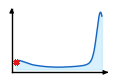

✅ Predicted Probability 分布图已保存到: figure\US_figure\predicted_prob_distribution.png
📊 总样本: 64,982 | Negative样本: 2,538 | 均值: 0.738


In [17]:
def visualize_predicted_prob_distribution(merged_data_for_plot, save_path=r'figure\US_figure\US_workflow\predicted_prob_distribution.png'):
    """
    参照 visualize_similarity 的设置绘制 predicted_prob 分布曲线
    - 不显示X轴与Y轴的tick与label
    - 参照 figsize 设置
    - 绘制分布曲线和阴影
    - 标记 negative_sample 的点
    """
    from scipy import stats
    
    # 提取 predicted_prob 数据
    predicted_prob = merged_data_for_plot['predicted_prob'].dropna()
    
    # 分离 negative_sample 数据
    neg_samples = merged_data_for_plot[merged_data_for_plot['sample_type'] == 'negative_sample']
    neg_prob = neg_samples['predicted_prob'].dropna()
    
    # 设置颜色（参照 visualize_similarity）
    curve_color = '#1565C0'  # 深蓝色
    fill_color = '#B3E5FC'   # 淡蓝色
    neg_color = '#E31A1C'    # 红色（标记negative_sample）
    
    # 设置图形参数（参照 visualize_similarity）
    fig, ax = plt.subplots(1, 1, figsize=(30/25.4, 20/25.4))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 6
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.labelcolor'] = 'black'
    plt.rcParams['ytick.labelcolor'] = 'black'
    
    # 数据裁剪（参照 visualize_similarity 的 _hist_bins_clip 逻辑）
    pct_lo, pct_hi = 0.5, 99.5
    lo, hi = np.percentile(predicted_prob, [pct_lo, pct_hi])
    prob_clip = np.clip(predicted_prob, lo, hi)
    
    # 计算KDE和绘制曲线
    kde = stats.gaussian_kde(prob_clip)
    x_min, x_max = np.min(prob_clip), np.max(prob_clip)
    x = np.linspace(x_min, x_max, 500)
    y = kde(x)
    
    # 绘制分布曲线
    ax.plot(x, y, color=curve_color, linewidth=1, label='Predicted Probability Distribution')
    
    # 绘制阴影区域
    ax.fill_between(x, 0, y, color=fill_color, alpha=0.5)
    
    # 标记 negative_sample 的点
    if len(neg_prob) > 0:
        # 在分布曲线上标记 negative_sample 的位置
        neg_y = kde(neg_prob)
        ax.scatter(neg_prob, neg_y, color=neg_color, s=8, alpha=0.8, 
                  marker='x', label='Negative Samples', zorder=10)
    
    # 设置背景颜色（参照 visualize_similarity）
    fig = ax.get_figure()
    
    # 修改：减少灰色区域，让图形更紧凑
    ax.set_position([0.05, 0.05, 0.9, 0.9])  # 留出10%的边距
    
    # 不显示网格
    ax.grid(False)
    
    # 设置刻度参数（参照 visualize_similarity）
    ax.tick_params(axis='both', which='major', width=0.5, length=2, labelsize=6, color='black')
    
    # 修改：连接x轴与y轴，显示底部和左侧边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)  # 显示底部边框
    ax.spines['left'].set_visible(True)    # 显示左侧边框
    
    # 设置边框颜色和宽度
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    # 不显示X轴与Y轴的tick与label（参照 visualize_similarity）
    ax.set_yticks([])
    ax.set_xticks([])
    
    # 修改：调整箭头位置，让它们从坐标轴末端开始
    ax.annotate('', xy=(1.02, 0), xycoords='axes fraction', xytext=(0.98, 0),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    ax.annotate('', xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 0.98),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    
    # 修改：使用更紧凑的布局
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    print(f"✅ Predicted Probability 分布图已保存到: {save_path}")
    
    # 简化的统计信息
    print(f"📊 总样本: {len(predicted_prob):,} | Negative样本: {len(neg_prob):,} | 均值: {np.mean(prob_clip):.3f}")
    
    return {
        "mean": np.mean(prob_clip),
        "std": np.std(prob_clip),
        "neg_samples_count": len(neg_prob),
        "total_samples_count": len(predicted_prob)
    }

# 使用函数绘制分布
if 'merged_data_for_plot' in locals():
    result = visualize_predicted_prob_distribution(
        merged_data_for_plot, 
        save_path=r'figure\US_figure\predicted_prob_distribution.png'
    )
else:
    print("⚠️ 请先确保 merged_data_for_plot 变量已定义")

# 碳汇部分附图

## Probability allocating 

In [ ]:
ds_new.landcover_at_abandonment.plot()
plt.title("Landcover at Abandonment (raw)")
plt.show()

[window] center snapped to ~ lat=36.862, lon=-120.621 (deg)
[window] unique classes in 12×12: [2 3 4]
[aggregation] window 12×12 → grid_size=4 → output 3×3


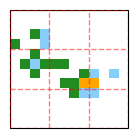

✅ 已保存: figure/US_figure/US_workflow\landcover_original_with_grid.png
[Type 4] counts range: 0.0 - 1.0
[Type 4] counts shape: (3, 3)


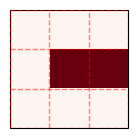

✅ 已保存: figure/US_figure/US_workflow\landcover_type4_counts_with_grid.png
[Type 2] counts range: 0.0 - 5.0
[Type 2] counts shape: (3, 3)


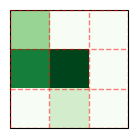

✅ 已保存: figure/US_figure/US_workflow\landcover_type2_counts_with_grid.png
[Type 3] counts range: 0.0 - 2.0
[Type 3] counts shape: (3, 3)


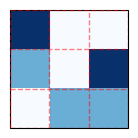

✅ 已保存: figure/US_figure/US_workflow\landcover_type3_counts_with_grid.png


In [28]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from tqdm.auto import tqdm

# ---------- 小工具：经度标准化 & 圆形距离 argmin ----------
def _lon_to_180(lon):
    """把任意经度数组规范到 [-180, 180)"""
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0

def _argmin_circular(lon_array_deg, target_deg):
    """
    在环形(360°)上找与 target_deg 最近的元素索引
    无论 lon 是 0–360 还是 -180–180 都能正确返回
    """
    lon_std = _lon_to_180(lon_array_deg)
    t = _lon_to_180(target_deg)
    d = np.abs(lon_std - t)
    d = np.minimum(d, 360.0 - d)
    return int(np.nanargmin(d))

# ---------- 1) 严格 50×50 窗口（使用slice方法） ----------
def extract_window_50x50(ds, var='landcover_at_abandonment',
                         center_lat=39.0, center_lon=-116.0, size=50):
    da = ds[var]
    lat_vals = da['lat'].values
    lon_vals = da['lon'].values

    # 经度用"圆形距离"取最近索引，纬度直接取最近索引
    i0 = int(np.argmin(np.abs(lat_vals - center_lat)))
    j0 = _argmin_circular(lon_vals, center_lon)

    half = size // 2
    i_start = max(0, i0 - half)
    i_end   = min(len(lat_vals), i_start + size)
    j_start = max(0, j0 - half)
    j_end   = min(len(lon_vals), j_start + size)

    # 若触边，反向补齐窗口大小
    if (i_end - i_start) < size:
        i_start = max(0, i_end - size)
    if (j_end - j_start) < size:
        j_start = max(0, j_end - size)

    # 使用slice方法而不是布尔索引
    ds_win = ds.isel(lat=slice(i_start, i_end), lon=slice(j_start, j_end))

    # 诊断：报告窗口中心的真实经纬度
    lat_c = float(ds_win['lat'].values[size//2])
    lon_c = float(_lon_to_180(ds_win['lon'].values[size//2]))
    print(f"[window] center snapped to ~ lat={lat_c:.3f}, lon={lon_c:.3f} (deg)")

    return ds_win

# ---------- 2) 把分类值规范到 1–9 的整数 ----------
def _prepare_classes_1to9(da):
    """
    将 da 规范为 1–9 的整数分类，范围外视作 NaN。
    适合后续等值比较与计数。
    """
    arr = np.array(da.values, dtype=float)
    # 若有 scale/offset 导致出现 1.0000001 之类，先四舍五入
    arr = np.rint(arr)
    # 范围外置 NaN
    arr[(arr < 1) | (arr > 9)] = np.nan
    # 转回 int16（NaN 需要 float，因此保持 float，后续 where/计数不受影响）
    return xr.DataArray(arr, coords=da.coords, dims=da.dims, name=da.name)

# ---------- 3) 计数/密度（在窗口上执行） ----------
def calculate_counts(ds, value=None, grid_size=10, var='landcover_at_abandonment'):
    da = _prepare_classes_1to9(ds[var])
    if value is None:
        mask = xr.where(np.isfinite(da), 1.0, 0.0)
    else:
        mask = xr.where(np.isfinite(da) & (da == float(value)), 1.0, 0.0)

    # 50×50 -> 10×10（每个 coarse 单元 5×5）
    counts = mask.coarsen(lon=grid_size, lat=grid_size, boundary='trim').sum()
    return counts

def calculate_weighted_densities(ds, grid_size=10, var='landcover_at_abandonment'):
    ds_density = xr.Dataset()
    total = calculate_counts(ds, value=None, grid_size=grid_size, var=var)
    ds_density['total_counts'] = total
    for value in tqdm(range(1, 10), desc='Calculating weighted densities'):
        c = calculate_counts(ds, value=value, grid_size=grid_size, var=var)
        ds_density[f'weighted_density_{value}'] = xr.where(total > 0, c/total, np.nan)
    return ds_density

# 修改绘图函数，确保网格线正确显示
def plot_landcover_analysis_separate(ds, center_lat=39.0, center_lon=-116.0,
                                    size=50, save_dir='figure/US_figure/US_workflow'):
    os.makedirs(save_dir, exist_ok=True)

    # 严格窗口
    ds_win = extract_window_50x50(ds, center_lat=center_lat, center_lon=center_lon, size=size)
    da_win = _prepare_classes_1to9(ds_win['landcover_at_abandonment'])

    # extent 与 origin
    lat_arr = ds_win['lat'].values
    lon_arr = _lon_to_180(ds_win['lon'].values)
    lat_min, lat_max = float(lat_arr.min()), float(lat_arr.max())
    lon_min, lon_max = float(lon_arr.min()), float(lon_arr.max())
    extent = [lon_min, lon_max, lat_min, lat_max]
    origin = 'lower' if lat_arr[1] > lat_arr[0] else 'upper'

    # 诊断：窗口里有什么类别？
    uniq = np.unique(da_win.values[~np.isnan(da_win.values)]).astype(int) if np.isfinite(da_win.values).any() else []
    print(f"[window] unique classes in {size}×{size}: {uniq}")

    # 设置图形尺寸为30mm x 30mm
    figsize_mm = (30/25.4, 30/25.4)

    # 动态调整聚合大小：确保至少有3×3的网格
    grid_size = max(1, size // 3)  # 12→4, 30→10, 50→16
    print(f"[aggregation] window {size}×{size} → grid_size={grid_size} → output {size//grid_size}×{size//grid_size}")

    # 计算聚合网格的边界线
    def add_aggregation_grid(ax, lat_arr, lon_arr, grid_size, extent):
        """在图上添加聚合网格的红线框"""
        # 计算网格边界
        lat_step = (lat_max - lat_min) / len(lat_arr)
        lon_step = (lon_max - lon_min) / len(lon_arr)
        
        # 计算聚合网格的边界线
        grid_lat_lines = []
        grid_lon_lines = []
        
        # 纬度边界线
        for i in range(0, len(lat_arr), grid_size):
            if i < len(lat_arr):
                lat_val = lat_min + i * lat_step
                grid_lat_lines.append(lat_val)
        
        # 经度边界线
        for j in range(0, len(lon_arr), grid_size):
            if j < len(lon_arr):
                lon_val = lon_min + j * lon_step
                grid_lon_lines.append(lon_val)
        
        # 添加最后一条边界线
        grid_lat_lines.append(lat_max)
        grid_lon_lines.append(lon_max)
        
        # 绘制垂直线（经度方向）
        for lon_val in grid_lon_lines:
            ax.plot([lon_val, lon_val], [lat_min, lat_max], 'r--', 
                   linewidth=1, alpha=0.5, transform=ccrs.PlateCarree(), zorder=10)
        
        # 绘制水平线（纬度方向）
        for lat_val in grid_lat_lines:
            ax.plot([lon_min, lon_max], [lat_val, lat_val], 'r--', 
                   linewidth=1, alpha=0.5, transform=ccrs.PlateCarree(), zorder=10)

    # 计算符合聚合分辨率的经纬网格
    def add_resolution_grid(ax, lat_arr, lon_arr, grid_size, extent):
        """Add lat/lon grid lines at the native data resolution (lat[1]-lat[0], lon[1]-lon[0])"""
        # 计算分辨率
        if len(lat_arr) > 1:
            lat_res = abs(lat_arr[1] - lat_arr[0])
        else:
            lat_res = 0.1  # fallback
        
        if len(lon_arr) > 1:
            lon_res = abs(lon_arr[1] - lon_arr[0])
        else:
            lon_res = 0.1  # fallback

        # 计算网格线位置
        lat_min, lat_max = min(lat_arr[0], lat_arr[-1]), max(lat_arr[0], lat_arr[-1])
        lon_min, lon_max = min(lon_arr[0], lon_arr[-1]), max(lon_arr[0], lon_arr[-1])

        # 生成经纬度网格线
        grid_lat_lines = np.arange(lat_min, lat_max + lat_res, lat_res)
        grid_lon_lines = np.arange(lon_min, lon_max + lon_res, lon_res)

        # 暂时不绘制

    # 颜色映射
    classes = {
        1: ('Cropland',               'white'),
        2: ('Forest',                 '#228B22'),
        3: ('Savanna',                '#87CEFA'),  
        4: ('Shrub',                  '#FFA500'),
        5: ('Grassland & Arid',       '#DEB887'),
        6: ('Wetland',                '#8B4513'),
        7: ('Built-up',               '#87CEEB'),
        8: ('Bare & Ice',             '#FF6347'),
        9: ('Water',                  '#1E90FF'),
    }
    cmap = ListedColormap([classes[i][1] for i in range(1, 10)])

    # ---- 第一张图：原始分类（带聚合网格线）
    fig1, ax1 = plt.subplots(1, 1, figsize=figsize_mm, 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    ax1.set_extent(extent, crs=ccrs.PlateCarree())
    
    data_plot = da_win.values.copy()
    data_plot[np.isnan(data_plot)] = 0
    
    im1 = ax1.imshow(data_plot, extent=extent, transform=ccrs.PlateCarree(),
                     cmap=cmap, vmin=1, vmax=9, origin=origin, interpolation='nearest', zorder=1)
    
    # 添加符合聚合分辨率的经纬网格
    add_resolution_grid(ax1, lat_arr, lon_arr, grid_size, extent)
    
    # 添加聚合网格线
    add_aggregation_grid(ax1, lat_arr, lon_arr, grid_size, extent)
    
    ax1.set_facecolor('white')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('')

    # 填满整个figsize
    fig1.subplots_adjust(left=0, right=1, top=1, bottom=0)
    out1 = os.path.join(save_dir, 'landcover_original_with_grid.png')
    plt.savefig(out1, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f'✅ 已保存: {out1}')

    # ---- 第二张图：Type 4 counts（带聚合网格线）
    fig2, ax2 = plt.subplots(1, 1, figsize=figsize_mm, 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    ax2.set_extent(extent, crs=ccrs.PlateCarree())
    
    c4 = calculate_counts(ds_win, value=4, grid_size=grid_size)
    print(f"[Type 4] counts range: {c4.min().values:.1f} - {c4.max().values:.1f}")
    print(f"[Type 4] counts shape: {c4.shape}")
    
    im2 = ax2.imshow(c4.values, extent=extent, transform=ccrs.PlateCarree(),
                     cmap='Reds', origin=origin, interpolation='nearest', zorder=1)
    
    # 添加符合聚合分辨率的经纬网格
    add_resolution_grid(ax2, lat_arr, lon_arr, grid_size, extent)
    
    # 添加聚合网格线
    add_aggregation_grid(ax2, lat_arr, lon_arr, grid_size, extent)
    
    ax2.set_facecolor('#f0f0f0')
    ax2.add_feature(cfeature.STATES, linewidth=0.3, zorder=3)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('')

    # 填满整个figsize
    fig2.subplots_adjust(left=0, right=1, top=1, bottom=0)
    out2 = os.path.join(save_dir, 'landcover_type4_counts_with_grid.png')
    plt.savefig(out2, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f'✅ 已保存: {out2}')

    # ---- 第三张图：Type 2 counts（带聚合网格线）
    fig3, ax3 = plt.subplots(1, 1, figsize=figsize_mm, 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    ax3.set_extent(extent, crs=ccrs.PlateCarree())
    
    c2 = calculate_counts(ds_win, value=2, grid_size=grid_size)
    print(f"[Type 2] counts range: {c2.min().values:.1f} - {c2.max().values:.1f}")
    print(f"[Type 2] counts shape: {c2.shape}")
    
    im3 = ax3.imshow(c2.values, extent=extent, transform=ccrs.PlateCarree(),
                     cmap='Greens', origin=origin, interpolation='nearest', zorder=1)
    
    # 添加符合聚合分辨率的经纬网格
    add_resolution_grid(ax3, lat_arr, lon_arr, grid_size, extent)
    
    # 添加聚合网格线
    add_aggregation_grid(ax3, lat_arr, lon_arr, grid_size, extent)
    
    ax1.set_facecolor('white') 
    ax3.add_feature(cfeature.STATES, linewidth=0.3, zorder=3)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('')

    # 填满整个figsize
    fig3.subplots_adjust(left=0, right=1, top=1, bottom=0)
    out3 = os.path.join(save_dir, 'landcover_type2_counts_with_grid.png')
    plt.savefig(out3, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f'✅ 已保存: {out3}')

    # ---- 第四张图：Type 3 counts（带聚合网格线）
    fig4, ax4 = plt.subplots(1, 1, figsize=figsize_mm, 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    ax4.set_extent(extent, crs=ccrs.PlateCarree())
    
    c3 = calculate_counts(ds_win, value=3, grid_size=grid_size)
    print(f"[Type 3] counts range: {c3.min().values:.1f} - {c3.max().values:.1f}")
    print(f"[Type 3] counts shape: {c3.shape}")
    
    im4 = ax4.imshow(c3.values, extent=extent, transform=ccrs.PlateCarree(),
                     cmap='Blues', origin=origin, interpolation='nearest', zorder=1)
    
    # 添加符合聚合分辨率的经纬网格
    add_resolution_grid(ax4, lat_arr, lon_arr, grid_size, extent)
    
    # 添加聚合网格线
    add_aggregation_grid(ax4, lat_arr, lon_arr, grid_size, extent)
    
    ax1.set_facecolor('white') 
    ax4.add_feature(cfeature.STATES, linewidth=0.3, zorder=3)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('')

    # 填满整个figsize
    fig4.subplots_adjust(left=0, right=1, top=1, bottom=0)
    out4 = os.path.join(save_dir, 'landcover_type3_counts_with_grid.png')
    plt.savefig(out4, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f'✅ 已保存: {out4}')

    return ds_win


ds_new = xr.open_dataset('data/4.landcover_abd.nc')
_ = plot_landcover_analysis_separate(
        ds_new,
        center_lat=36.8633,
        center_lon=-120.6167,
        size=12,
        save_dir='figure/US_figure/US_workflow'
    )

## Carbon intensity yearly variation 

In [3]:
import pandas as pd
import numpy as np
df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')



emission_intensity = pd.DataFrame({
    'year': ['2018',  '2030', '2035', '2040'],
    'CO2_g_per_kWh': [400.3,  302,  279.2, 261.1]
})
# Transform pv_transform (2020 emission factor) to 2030, 2040, 2050 using emission_intensity
pv_transform_2020 = 352  
# Interpolate emission intensity for 2020, 2030, 2040, 2050
years_target = [2020, 2030, 2040, 2050]
em_factors = np.interp(
    years_target,
    emission_intensity['year'].astype(int),
    emission_intensity['CO2_g_per_kWh']
)

# Calculate scaling factors relative to 2020
scaling_factors = em_factors / em_factors[0]

# 生成一个pv_transfer的dataframe
pv_transfer = pd.DataFrame({
    'year': [2020, 2030, 2040, 2050],
    'pv_transform': [pv_transform_2020] + list(pv_transform_2020 * scaling_factors[1:])
})

# 计算每10年区间的累计光伏转化能力，并最终汇总到2050
years = [2020, 2030, 2040, 2050]

for idx in range(len(years)-1):
    y_start, y_end = years[idx], years[idx+1]
    pv_start = pv_transfer.loc[pv_transfer['year'] == y_start, 'pv_transform'].values[0]
    pv_end = pv_transfer.loc[pv_transfer['year'] == y_end, 'pv_transform'].values[0]
    # 线性插值每年pv_transform，累计10年
    pv_sum = 0
    for y in range(y_start, y_end):
        pv_y = pv_start + (pv_end - pv_start) * (y - y_start) / (y_end - y_start)
        pv_sum += df_analysis['E_yr_pixel'] * pv_y / 1000 / 1000 * 0.27 / (df_analysis['area_m2'] / 10000)
    df_analysis[f'pv_potential_{y_start}_{y_end-1}_sum'] = pv_sum

# 汇总2020-2050累计值，汇总site的累计光伏减排能力(t C)
df_analysis['pv_potential_total(t)'] = sum(
    df_analysis[f'pv_potential_{years[i]}_{years[i+1]-1}_sum'] for i in range(len(years)-1)
)

df_analysis['power_generation_kwha'] = df_analysis['E_yr_pixel'] * 30 / df_analysis['area_m2'] * 10000
# emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','LNCS_expect','power_generation_kwha', 'area_m2']].copy()


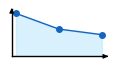

✅ PV Potential趋势图已保存到: figure\US_figure\pv_potential_trend.png
📊 2020-2029: 127,743,642.42
📊 2030-2039: 104,385,602.45
📊 2040-2049: 96,105,646.43


In [9]:
def plot_pv_potential_trend(df_analysis, save_path=r'figure\US_figure\pv_potential_trend.png'):
    """
    绘制PV potential随时间变化的趋势曲线
    使用与 visualize_predicted_prob_distribution 相同的字体和图形设置
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 定义变量列表和时间标签
    varlist = ['pv_potential_2020_2029_sum', 'pv_potential_2030_2039_sum', 'pv_potential_2040_2049_sum']
    time_labels = ['2020-2029', '2030-2039', '2040-2049']
    
    # 计算每个变量的总和
    values = [df_analysis[var].sum() for var in varlist]
    
    # 设置颜色（参照 visualize_predicted_prob_distribution）
    curve_color = '#1565C0'  # 深蓝色
    fill_color = '#B3E5FC'   # 淡蓝色
    
    # 设置图形参数（参照 visualize_predicted_prob_distribution）
    fig, ax = plt.subplots(1, 1, figsize=(30/25.4, 15/25.4))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 6
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.labelcolor'] = 'black'
    plt.rcParams['ytick.labelcolor'] = 'black'
    
    # 计算y轴范围：从最大值的1/2开始
    y_max = max(values)
    y_min = y_max * 0.5
    
    # 绘制曲线
    x = np.arange(len(varlist))
    ax.plot(x, values, color=curve_color, linewidth=1, marker='o', markersize=4)
    
    # 绘制阴影区域（从y_min开始）
    ax.fill_between(x, y_min, values, color=fill_color, alpha=0.5)
    
    # 设置y轴范围
    ax.set_ylim(y_min, y_max * 1.05)  # 顶部留5%空间
    
    # 设置图形位置
    ax.set_position([0.05, 0.05, 0.9, 0.9])
    
    # 不显示网格
    ax.grid(False)
    
    # 设置刻度参数
    ax.tick_params(axis='both', which='major', width=0.5, length=2, labelsize=6, color='black')
    
    # 设置边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    # 不显示tick和label（参照原函数）
    ax.set_yticks([])
    ax.set_xticks([])
    
    # 添加箭头
    ax.annotate('', xy=(1.02, 0), xycoords='axes fraction', xytext=(0.98, 0),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    ax.annotate('', xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 0.98),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    
    # 调整布局
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    print(f"✅ PV Potential趋势图已保存到: {save_path}")
    
    # 输出统计信息
    for label, val in zip(time_labels, values):
        print(f"📊 {label}: {val:,.2f}")
    
    return {
        "time_periods": time_labels,
        "values": values
    }

# 使用函数绘制趋势图
if 'df_analysis' in locals():
    result = plot_pv_potential_trend(
        df_analysis, 
        save_path=r'figure\US_figure\pv_potential_trend.png'
    )
else:
    print("⚠️ 请先确保 df_analysis 变量已定义")

# 经济部分附图

## 政策情景累积图

### Load data for economic 

In [ ]:
import pandas as pd 
df_economic = pd.read_csv('data/US_data/df_economic.csv') 
df_economic

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
from scipy import stats
from scipy.stats import norm


def calculate_policy_scenarios(df_economic):
    """
    计算部分：对df_economic进行政策匹配，为每个像素生成P1、P2、P3数据
    
    Parameters:
    -----------
    df_economic : DataFrame
        经济数据，包含policy_category, lat, lon, analysis_year, net_npv_usd等字段
    
    Returns:
    --------
    dict : 包含以下键值对：
        - 'pixel_year_data': DataFrame with columns [policy_group, lat, lon, analysis_year, net_npv_usd]
        - 'policy_stats': dict with statistics for each policy (P1, P2, P3)
        - 'years': array of unique years
    """
    def match_policy(val):
        s = str(val)
        if 'P1' in s: return 'P1'
        if 'P2' in s: return 'P2'
        if 'P3' in s: return 'P3'
        return 'Other'
    
    # 复制并匹配政策
    df = df_economic.copy()
    df['policy_group'] = df['policy_category'].astype(str).apply(match_policy)
    df = df[df['policy_group'].isin(['P1', 'P2', 'P3'])]
    
    # 获取年份
    years = np.sort(df['analysis_year'].unique())
    
    # 为每个像素-年份计算平均值（处理可能的重复数据）
    pixel_year_data = (df.groupby(['policy_group', 'lat', 'lon', 'analysis_year'], as_index=False)
                          ['net_npv_usd'].mean())
    
    # 计算各政策的统计信息
    policy_stats = {}
    policy_groups = ['P1', 'P2', 'P3']
    
    print("="*80)
    print("各政策情景30年期间平均NPV统计分析")
    print("="*80)
    
    for policy in policy_groups:
        py = pixel_year_data[pixel_year_data['policy_group'] == policy]
        
        if py.empty:
            policy_stats[policy] = None
            continue
        
        # 按年份计算均值、标准差和样本数量
        year_stats = py.groupby('analysis_year')['net_npv_usd'].agg(['mean', 'std', 'count'])
        year_stats = year_stats.reindex(years)
        
        year_means = year_stats['mean']
        year_stds = year_stats['std']
        year_ns = year_stats['count']
        
        # 计算30年期间的统计量
        overall_mean = year_means.mean()
        overall_std = year_means.std(ddof=1)
        n_years = len(years)
        standard_error = overall_std / np.sqrt(n_years)
        confidence_interval_95 = 1.96 * standard_error
        
        # 分位数计算
        quantiles = py.groupby('analysis_year')['net_npv_usd'].quantile([0.25, 0.75]).unstack()
        quantiles = quantiles.reindex(years)
        
        # 存储统计结果（添加year_stds和year_ns）
        policy_stats[policy] = {
            'n_years': n_years,
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'standard_error': standard_error,
            'ci_95_lower': overall_mean - confidence_interval_95,
            'ci_95_upper': overall_mean + confidence_interval_95,
            'year_means': year_means,
            'year_stds': year_stds,      # 新增：每年的标准差
            'year_ns': year_ns,          # 新增：每年的样本数量
            'quantiles': quantiles
        }
        
        # 打印结果
        print(f"\n{policy} 政策情景:")
        print(f"  年份数量: {n_years}")
        print(f"  30年平均NPV: {overall_mean:,.2f} USD/ha")
        print(f"  标准误: {standard_error:,.2f} USD/ha")
        print(f"  95%置信区间: [{overall_mean - confidence_interval_95:,.2f}, "
              f"{overall_mean + confidence_interval_95:,.2f}] USD/ha")
        
        # 打印各年份的统计信息
        print(f"  各年份统计信息:")
        for year in years:
            mean_val = year_means.get(year, np.nan)
            std_val = year_stds.get(year, np.nan)
            n_val = year_ns.get(year, 0)
            print(f"    {year}: 均值={mean_val:,.2f}, 标准差={std_val:,.2f}, 样本数={int(n_val)}")
    
    # 政策间比较分析
    print("\n" + "="*80)
    print("政策情景间比较分析")
    print("="*80)
    
    valid_policies = {k: v for k, v in policy_stats.items() if v is not None}
    
    if len(valid_policies) > 1:
        sorted_policies = sorted(valid_policies.items(), 
                               key=lambda x: x[1]['overall_mean'], 
                               reverse=True)
        
        print("\n按30年平均NPV排序:")
        for i, (policy, stats) in enumerate(sorted_policies, 1):
            print(f"  {i}. {policy}: {stats['overall_mean']:,.2f} ± {stats['standard_error']:,.2f} USD/ha")
        
        print("\n政策间差异分析:")
        policy_names = list(valid_policies.keys())
        for i in range(len(policy_names)):
            for j in range(i+1, len(policy_names)):
                policy1, policy2 = policy_names[i], policy_names[j]
                stats1, stats2 = valid_policies[policy1], valid_policies[policy2]
                
                mean_diff = stats1['overall_mean'] - stats2['overall_mean']
                se_diff = np.sqrt(stats1['standard_error']**2 + stats2['standard_error']**2)
                t_stat = mean_diff / se_diff
                p_value = 2 * (1 - norm.cdf(abs(t_stat)))
                
                print(f"  {policy1} vs {policy2}: {mean_diff:+,.2f} ± {se_diff:,.2f} USD/ha")
                print(f"    t-stat: {t_stat:.3f}, p-value: {p_value:.4f}")
                
                if p_value < 0.001:
                    significance = "***"
                elif p_value < 0.01:
                    significance = "**"
                elif p_value < 0.05:
                    significance = "*"
                else:
                    significance = "ns"
                print(f"    显著性: {significance}")
    
    print("\n" + "="*80)
    
    return {
        'pixel_year_data': pixel_year_data,
        'policy_stats': policy_stats,
        'years': years
    }

def plot_policy_scenarios(calculation_results, save_dir=r'figure\US_figure\US_workflow'):
    """
    绘图部分：基于计算结果绘制政策情景分析图（极简版本）
    
    Parameters:
    -----------
    calculation_results : dict
        calculate_policy_scenarios函数的输出结果
    save_dir : str
        图片保存目录
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    pixel_year_data = calculation_results['pixel_year_data']
    policy_stats = calculation_results['policy_stats']
    years = calculation_results['years']
    
    policy_groups = ['P1', 'P2', 'P3']
    
    # 设置字体为Arial
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # 总figsize: 45mm x 15mm = 45/25.4 x 15/25.4 inches
    fig, axes = plt.subplots(1, 3, figsize=(45/25.4, 12/25.4), sharex=True)
    
    # 设置整个画布背景为灰色
    fig.patch.set_facecolor('#f5f5f5')  # 浅灰色
    
    # 颜色方案
    colors = {
        'P1': dict(mean='#4E4EFF', ci='#6B6BFF', pixel='#BBBBBB', 
                   band_75='#E6E6FF'),
        'P2': dict(mean='#E6007A', ci='#FF4FA3', pixel='#BBBBBB', 
                   band_75='#F9D1E6'),
        'P3': dict(mean='#8B3EFF', ci='#B266FF', pixel='#BBBBBB', 
                   band_75='#E6D6FF')
    }
    
    for i, (ax, policy) in enumerate(zip(axes, policy_groups)):

        # 设置每个子图的背景为白色
        ax.set_facecolor('white')
        left = 0.1 + i * 0.3  # 根据子图索引调整左侧位置
        ax.set_position([left, 0.2, 0.25, 0.6]) 
        py = pixel_year_data[pixel_year_data['policy_group'] == policy]
        stats = policy_stats.get(policy)

        if py.empty or stats is None:
            ax.text(0.5, 0.5, f'No data for {policy}', 
                   ha='center', va='center', transform=ax.transAxes)
            continue

        # 像素曲线（极低透明度）
        pivot = (py.pivot_table(index=['lat', 'lon'], columns='analysis_year',
                                values='net_npv_usd', aggfunc='mean')
                 .reset_index())
        
        segs = []
        for _, row in pivot.iterrows():
            xs, ys = [], []
            for y in years:
                v = row.get(y, np.nan)
                if pd.notna(v):
                    xs.append(float(y))
                    ys.append(float(v))
            if len(xs) > 1:
                segs.append(np.column_stack([xs, ys]))
        
        if segs:
            lc = LineCollection(segs, colors=colors[policy]['pixel'],
                                linewidths=0.25, alpha=0.04, zorder=1)
            lc.set_rasterized(True)
            ax.add_collection(lc)
        
        # 95% CI for mean (assuming t-distribution)
        year_means = stats['year_means']
        year_stds = stats['year_stds']
        year_ns = stats['year_ns']
        x_ci = years
        mu = year_means.values

        # Calculate 95% CI using t-distribution
        from scipy.stats import t
        ci_low = []
        ci_high = []
        for mean, std, n in zip(year_means.values, year_stds.values, year_ns.values):
            if n > 1 and not np.isnan(std):
                tval = t.ppf(0.975, n-1)
                se = std / np.sqrt(n)
                ci_low.append(mean - tval * se)
                ci_high.append(mean + tval * se)
            else:
                ci_low.append(np.nan)
                ci_high.append(np.nan)
        ci_low = np.array(ci_low)
        ci_high = np.array(ci_high)

        ax.fill_between(x_ci, ci_low, ci_high, color=colors[policy]['band_75'], 
                        alpha=1, zorder=3, linewidth=0)

        # 均值线
        mean_line, = ax.plot(x_ci, mu, color=colors[policy]['mean'], linewidth=1.5,
                             marker='o', markersize=3, zorder=12)
        # 不显示标题
        # ax.set_title() - 移除
        
        # 网格
        ax.grid(True, alpha=0.25, linewidth=0.3, zorder=0)
        ax.set_axisbelow(True)
        
        # 0线
        ax.axhline(0, color='#FF1744', linestyle='--', linewidth=1, alpha=0.8, zorder=20)
        
        # 智能y轴范围
        vals = py['net_npv_usd'].to_numpy()
        data_min, data_max = np.nanmin(vals), np.nanmax(vals)
        q01, q99 = np.nanpercentile(vals, [1, 99])
        
        if policy == 'P1':
            lo = min(q01, data_min) - 0.1e6
            hi = max(q99, 0.1e6) + 0.2e6
            ax.set_ylim(lo, hi)
        elif policy == 'P2':
            lo = min(q01, data_min) - 0.2e6
            hi = max(data_min, data_max) + 0.1e6
            ax.set_ylim(lo, hi)
        elif policy == 'P3':
            lo = min(data_min, -0.5e6) - 0.3e6
            hi = max(q99, data_max) + 0.15e6
            ax.set_ylim(lo, hi)
        
        # 移除所有刻度和标签
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        # 在x与y轴的末端加入箭头
        # x轴箭头
        ax.annotate(
            '', 
            xy=(1.02, 0), xycoords='axes fraction', 
            xytext=(0.98, 0), 
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True)
        )
        # y轴箭头
        ax.annotate(
            '', 
            xy=(0, 1.02), xycoords='axes fraction', 
            xytext=(0, 0.98), 
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True)
        )
        
        # 不显示图例
        # ax.legend() - 移除
    
    # 不显示x和y的标签
    # axes[0].set_ylabel() - 移除
    
    # 边框设置
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for side in ['left', 'bottom']:
            ax.spines[side].set_linewidth(1)
            ax.spines[side].set_color('black')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.3)
    
    # 保存图片
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    fig.savefig(f'{save_dir}/Figure_policy_scenarios_analysis.eps', 
                bbox_inches='tight', dpi=300, format='eps')
    fig.savefig(f'{save_dir}/Figure_policy_scenarios_analysis.png', 
                bbox_inches='tight', dpi=300, format='png')
    
    print(f"\n✅ 图片已保存到: {save_dir}")
    
    return fig, axes


# 使用示例
# 第一步：计算
calculation_results = calculate_policy_scenarios(df_economic)

# 第二步：绘图
fig_policy, axes_policy = plot_policy_scenarios(
    calculation_results, 
    save_dir=r'figure\US_figure\US_workflow'
)

plt.show()


print("政策情景分析完成！")

各政策情景30年期间平均NPV统计分析

P1 政策情景:
  年份数量: 4
  30年平均NPV: -2,009,139.71 USD/ha
  标准误: 151,194.20 USD/ha
  95%置信区间: [-2,305,480.35, -1,712,799.07] USD/ha
  各年份统计信息:
    2020: 均值=-2,282,633.71, 标准差=480.44, 样本数=70337
    2030: 均值=-2,232,009.84, 标准差=209,467.53, 样本数=70337
    2040: 均值=-1,876,407.85, 标准差=345,711.23, 样本数=70337
    2050: 均值=-1,645,507.42, 标准差=421,491.84, 样本数=70337

P2 政策情景:
  年份数量: 4
  30年平均NPV: -1,152,359.52 USD/ha
  标准误: 417,812.80 USD/ha
  95%置信区间: [-1,971,272.61, -333,446.43] USD/ha
  各年份统计信息:
    2020: 均值=-2,156,610.39, 标准差=480.44, 样本数=70337
    2030: 均值=-1,478,838.01, 标准差=317,883.15, 样本数=70337
    2040: 均值=-704,114.75, 标准差=540,759.80, 样本数=70337
    2050: 均值=-269,874.92, 标准差=658,985.94, 样本数=70337


## 机会成本柱状图


其实这个值主要变动的就是Agricultural值，其余两个值forset、natural实际上都不会变动（而且都为负数）。

因此我思考了下，改变一下这个图的组织形式，变成：散点图（在每个政策Group中，根据state再计算mean，并且用state所属于的不同'A Climate Zone'分配对应数据标签）+ 柱状堆积图（注意orset、natural是负数的逆向堆积，用来展示主要的成本结构） 

根据每个pixel在P2,P2,P3 group 计算出来的 mean cost > 0 进行散点标注。标注他们来自于哪个state并且用颜色表示（标记这个state对应的散点）


需要根据按照P1,P2,P3聚合后生成的df，根据'lat','lon'与us_states_4326执行gpd.sjoin。然后挂上对应地理范围的us_states_4326['STUSPS'].unique()和df_climate_zone['A Climate Zone'].unique()。其中，us_states_4326['STUSPS'].unique()需要先匹配上df_climate_zone['State'].unique()值，才能挂上A Climate Zone字段（其中，请你把'Hot-Dry'与'Mixed-Dry'合并成'Dry'； 'Cold'和'Very Cold'合并成'cold'；'Hot-Humid'和'Mixed-Humid'合并成'Humid'，这样总共就有5种数据标签）。请你执行的时候，打印一下匹配情况。



all_climate_zones = sorted(df_zone['BA Climate Zone'].unique())
all_climate_zones = [z for z in all_climate_zones if pd.notna(z)]
climate_colors = {
    'Hot-Dry': '#FF6B6B',
    'Mixed-Dry': '#FF8E8E', 
    'Cold': '#6C5CE7',
    'Very Cold': '#8A7FE8',
    'Hot-Humid': '#F9CA24',
    'Mixed-Humid': '#45B7D1',
    'Marine': '#4ECDC4',
    'Subarctic': '#A8E6CF'
}

In [ ]:
import pandas as pd

df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')


In [ ]:
df_climate_zone=pd.read_csv(r'data\US_data\df_zones.csv')


In [ ]:
df_climate_zone['State'].unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UM', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI',
       'WV', 'WY'], dtype=object)

In [ ]:
import matplotlib.pyplot as plt

def create_opportunity_cost_unified(df_economic, df_agricultural_npv, df_afforestation_npv, df_natural_npv, 
                                    us_states_4326, df_climate_zone):
    """
    优化版机会成本分析图：散点图+柱状堆积图
    重点优化计算效率
    去掉双Y轴，所有内容绘制在同一主坐标轴上
    """
    
    # 设置字体
    plt.rcParams['font.family'] = 'Arial'
    
    print("开始优化版机会成本分析...")
    
    # 1. 数据预处理 - 向量化操作
    print("1. 数据预处理...")
    
    # RCP映射 - 使用字典映射替代apply
    rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5', 'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }
    
    # 2. 高效处理df_economic
    print("2. 处理经济数据...")
    
    # 使用向量化操作替代apply
    df_economic_2050 = df_economic[df_economic['analysis_year'] == 2050].copy()
    
    # 向量化RCP映射
    df_economic_2050['mapped_rcp'] = df_economic_2050['pv_category'].map(rcp_mapping)
    
    # 向量化政策分组
    df_economic_2050['policy_group'] = df_economic_2050['policy_category'].str.extract(r'(P[123])')[0]
    
    # 过滤有效数据
    valid_mask = df_economic_2050['policy_group'].isin(['P1', 'P2', 'P3'])
    df_economic_2050 = df_economic_2050[valid_mask]
    
    # 3. 高效聚合 - 使用groupby.agg一次性计算
    print("3. 数据聚合...")
    
    agg_cols = ['lat', 'lon', 'policy_category', 'policy_group', 'mapped_rcp']
    df_economic_agg = df_economic_2050.groupby(agg_cols).agg({
        'net_npv_usd': 'mean',
        'net_cost_usd': 'mean'
    }).reset_index()
    
    print(f"聚合后数据: {len(df_economic_agg)} 行")
    
    # 4. 处理机会成本数据 - 先统一列名再处理
    print("4. 处理机会成本数据...")
    
    # 先统一列名为小写，避免大小写问题
    opp_data = {}
    # tqdm用于显示进度条
    for name, df in tqdm([('agri', df_agricultural_npv), ('affor', df_afforestation_npv), ('nat', df_natural_npv)], desc="处理机会成本数据"):
        df_temp = df.copy()
        # 统一列名为小写
        df_temp.columns = df_temp.columns.str.lower()
        
        # 现在可以安全地访问小写列名
        df_temp = df_temp[df_temp['analysis_year'] == 2050][['lat', 'lon', 'rcp_category', 'cumulative_npv_usd']].copy()
        df_temp.columns = ['lat', 'lon', 'rcp_category', f'{name}_npv']
        opp_data[name] = df_temp
    
    # 5. 高效合并机会成本数据
    print("5. 合并机会成本数据...")
    
    # 使用reduce进行多表合并
    from functools import reduce
    # tqdm用于显示合并进度
    opp_data_list = list(opp_data.values())
    df_opp_merged = opp_data_list[0]
    for right in tqdm(opp_data_list[1:], desc="合并机会成本数据"):
        df_opp_merged = pd.merge(df_opp_merged, right, on=['lat', 'lon', 'rcp_category'], how='inner')
    
    print(f"合并后的机会成本数据: {len(df_opp_merged)} 行")
    
    # 6. 最终合并 - 使用merge_asof优化大数据集合并
    print("6. 最终数据合并...")
    
    # 先排序以提高merge效率
    df_economic_agg = df_economic_agg.sort_values(['lat', 'lon', 'mapped_rcp'])
    df_opp_merged = df_opp_merged.sort_values(['lat', 'lon', 'rcp_category'])
    
    df_final = pd.merge(df_economic_agg, df_opp_merged, 
                        left_on=['lat', 'lon', 'mapped_rcp'], 
                        right_on=['lat', 'lon', 'rcp_category'], 
                        how='inner')
    
    print(f"最终数据: {len(df_final)} 行")
    
    # 7. 地理信息匹配 - 优化空间连接
    print("7. 地理信息匹配...")
    
    # 创建Point几何对象 - 向量化
    geometry = gpd.points_from_xy(df_final['lon'], df_final['lat'])
    gdf_final = gpd.GeoDataFrame(df_final, geometry=geometry, crs='EPSG:4326')
    
    # 优化空间连接 - 只保留必要的列
    states_simple = us_states_4326[['STUSPS', 'geometry']].copy()
    
    # 执行空间连接
    gdf_with_states = gpd.sjoin(gdf_final, states_simple, how='left', predicate='within')
    
    # 8. 气候区域匹配 - 优化匹配逻辑
    print("8. 气候区域匹配...")
    
    # 创建州名映射字典
    state_climate_map = dict(zip(df_climate_zone['State'], df_climate_zone['BA Climate Zone']))
    
    # 气候区域合并映射
    climate_merge_map = {
        'Hot-Dry': 'Dry', 'Mixed-Dry': 'Dry',
        'Cold': 'Cold', 'Very Cold': 'Cold',
        'Hot-Humid': 'Humid', 'Mixed-Humid': 'Humid',
        'Marine': 'Marine', 'Subarctic': 'Subarctic'
    }
    
    # 向量化气候区域匹配
    gdf_with_states['climate_zone'] = gdf_with_states['STUSPS'].map(state_climate_map)
    gdf_with_states['climate_zone_merged'] = gdf_with_states['climate_zone'].map(climate_merge_map)
    
    # 打印匹配情况
    print("气候区域匹配情况:")
    print(gdf_with_states['climate_zone_merged'].value_counts())
    
    # 9. 计算州级别的统计量
    print("9. 计算州级别统计量...")
    
    # 按州和政策组聚合，计算每个州的平均机会成本
    state_policy_stats = gdf_with_states.groupby(['STUSPS', 'policy_group', 'climate_zone_merged']).agg({
        'agri_npv': 'mean',
        'affor_npv': 'mean',
        'nat_npv': 'mean'
    }).reset_index()
    
    # 计算每个州在每个政策组下的总机会成本
    state_policy_stats['total_opportunity_cost'] = (
        state_policy_stats['agri_npv'] + 
        state_policy_stats['affor_npv'] + 
        state_policy_stats['nat_npv']
    )
    
    print("州级别统计结果:")
    print(state_policy_stats.head(10))
    
    # 10. 绘图数据准备 - 进一步聚合三个政策组
    print("10. 准备绘图数据...")
    
    # 为散点图准备数据 - 按州和气候区域聚合，计算三个政策组的均值和标准差
    scatter_data_aggregated = state_policy_stats.groupby(['STUSPS', 'climate_zone_merged']).agg({
        'total_opportunity_cost': ['mean', 'std', 'count']
    }).reset_index()
    
    # 扁平化列名
    scatter_data_aggregated.columns = ['STUSPS', 'climate_zone_merged', 'mean_cost', 'std_cost', 'count']
    
    # 计算堆积图数据 - 计算三个政策组的整体均值和标准差
    stats_overall = gdf_with_states.groupby('policy_group').agg({
        'agri_npv': ['count', 'mean', 'std'],
        'affor_npv': ['count', 'mean', 'std'],
        'nat_npv': ['count', 'mean', 'std']
    }).round(2)
    
    # 扁平化列名
    stats_overall.columns = [f"{col[1]}_{col[0]}" if col[1] != '' else col[0] for col in stats_overall.columns]
    
    # 计算整体均值（三个政策组的平均）
    overall_means = stats_overall.mean()
    
    # 计算整体标准差（三个政策组的标准差）
    overall_stds = stats_overall.std()
    
    print("整体统计结果:")
    print(f"Agricultural NPV: {overall_means['mean_agri_npv']:.2f} ± {overall_stds['mean_agri_npv']:.2f}")
    print(f"Afforestation NPV: {overall_means['mean_affor_npv']:.2f} ± {overall_stds['mean_affor_npv']:.2f}")
    print(f"Natural NPV: {overall_means['mean_nat_npv']:.2f} ± {overall_stds['mean_nat_npv']:.2f}")
    
    # 分离正值和负值（使用整体均值）
    positive_data = np.array([
        [max(0, overall_means['mean_agri_npv']),
         max(0, overall_means['mean_affor_npv']),
         max(0, overall_means['mean_nat_npv'])]
    ])
    
    negative_data = np.array([
        [min(0, overall_means['mean_agri_npv']),
         min(0, overall_means['mean_affor_npv']),
         min(0, overall_means['mean_nat_npv'])]
    ])
    
    # 计算误差棒数据
    error_data = np.array([
        [overall_stds['mean_agri_npv'],
         overall_stds['mean_affor_npv'],
         overall_stds['mean_nat_npv']]
    ])
    

    
    # 11. 创建统一坐标系图形
    print("11. 创建统一坐标系图形...")
    
    # 调整图幅为更窄的比例，例如4x4
    fig, ax = plt.subplots(figsize=(5, 4.5))
    
    # 绘制散点图（单个组合）
    print("绘制散点图...")
    plot_aggregated_scatter(ax, scatter_data_aggregated)
    
    # 绘制堆叠图（直接在主坐标轴ax上，去掉双Y轴）
    print("绘制堆叠图...")
    plot_overall_stacked_bars(ax, positive_data, negative_data, error_data)
    
    plt.tight_layout()
    return fig, ax



def plot_aggregated_scatter(ax, scatter_data_aggregated):
    """聚合散点 + 稳定的 Top5 标签（可复现、避免飞出与重叠）"""
    climate_styles = {
        'Dry':       {'color': '#D7263D', 'marker': 'o'},
        'Cold':      {'color': '#3B1F5A', 'marker': 's'},
        'Humid':     {'color': '#F4B400', 'marker': 'D'},
        'Marine':    {'color': '#218380', 'marker': '^'},
        'Subarctic': {'color': '#1B9AAA', 'marker': 'P'},
    }

    # —— 1) 更紧凑的抖动（点与标签共享），加右移 x_offset —— 
    rng = np.random.default_rng(7)  # 固定种子，保证每次一致
    x_offset = 0.25  # 向右移动，让散点图更靠右
    x_center = x_offset
    jitter_w = 0.11  # 抖动范围缩小，更紧凑
    state_xy = {}  # STUSPS -> (x, y)
    legend_handles = []
    legend_labels = []
    all_xs = []

    for cz, style in climate_styles.items():
        sub = scatter_data_aggregated[scatter_data_aggregated['climate_zone_merged'] == cz]
        if sub.empty:
            continue
        
        xs, ys = [], []
        for _, r in sub.iterrows():
            x = x_center + rng.normal(0, jitter_w)
            y = float(r['mean_cost'])
            state_xy[r['STUSPS']] = (x, y)
            xs.append(x); ys.append(y)
        all_xs.extend(xs)
        scatter = ax.scatter(
            xs, ys,
            c=style['color'], marker=style['marker'], s=45, alpha=0.85,
            edgecolors='white', linewidth=0.6,
            zorder=3
        )
        legend_handles.append(scatter)
        legend_labels.append(cz)

    # —— 2) y 轴范围（给标签留头部空隙）——
    if state_xy:
        ymax = max(y for _, y in state_xy.values())
    else:
        ymax = 1.0
    ymin = 0.0
    pad = max(120.0, 0.12 * (ymax - ymin))
    ax.set_ylim(ymin, ymax + pad)

    # x 轴设置：确保标签在散点图中心
    if all_xs:
        scatter_center = float(np.mean(all_xs))  # 散点图的真实中心
    else:
        scatter_center = x_offset
    
    # 设置X轴刻度，确保"Average P1+P2+P3"标签在散点图中心
    ax.set_xticks([scatter_center])
    ax.set_xticklabels(['Average P1+P2+P3'], fontsize=12, fontweight='bold')
    
    # 设置X轴范围，确保散点图居中显示，给右侧留出足够空间
    # x_range = 0.25  # 散点图的总宽度，稍微缩小
    # ax.set_xlim(scatter_center - x_range/2, scatter_center + x_range/2)
    
    ax.set_ylabel('Total Opportunity Cost (USD/ha)', fontsize=10, fontweight='bold')
    ax.axhline(0, color='#B20000', linestyle='--', alpha=1, linewidth=2.0, zorder=1)
    ax.grid(True, alpha=0.2, zorder=0)

    # —— 3) Top5 标签：就近择优 + 防重叠 + 保持在轴域内 —— #
    if state_xy:
        top5 = sorted(state_xy.items(), key=lambda kv: kv[1][1], reverse=True)[:5]
        candidates = [(10,10), (14,0), (10,-10),
                      (-10,10), (-14,0), (-10,-10),
                      (0,12), (0,-12)]
        lab_w_pt, lab_h_pt = 22, 14
        dpi = ax.figure.dpi
        pt2px = dpi / 72.0
        placed = []
        ax_bbox_px = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
        ax_bbox_px = [ax_bbox_px.x0*dpi, ax_bbox_px.y0*dpi, ax_bbox_px.x1*dpi, ax_bbox_px.y1*dpi]

        def rect_of(xd, yd, dx_pt, dy_pt):
            x_px, y_px = ax.transData.transform((xd, yd))
            dx_px, dy_px = dx_pt*pt2px, dy_pt*pt2px
            w_px, h_px = lab_w_pt*pt2px, lab_h_pt*pt2px
            return [x_px+dx_px, y_px+dy_px, x_px+dx_px+w_px, y_px+dy_px+h_px]

        def iou_with_placed(R):
            x0,y0,x1,y1 = R
            area = 0.0
            for A in placed:
                ax0,ay0,ax1,ay1 = A
                ix0, iy0 = max(x0,ax0), max(y0,ay0)
                ix1, iy1 = min(x1,ax1), min(y1,ay1)
                if ix1>ix0 and iy1>iy0:
                    area += (ix1-ix0)*(iy1-iy0)
            return area

        def inside_axes(R):
            pad = 2*pt2px
            x0,y0,x1,y1 = R
            ax0,ay0,ax1,ay1 = ax_bbox_px
            return (x0>=ax0+pad) and (y0>=ay0+pad) and (x1<=ax1-pad) and (y1<=ay1-pad)

        for st,(x,y) in top5:
            best = None
            best_score = (1e18, 1e18)
            for dx,dy in candidates:
                R = rect_of(x,y,dx,dy)
                overlap = iou_with_placed(R)
                dist = abs(dx)+abs(dy)
                if not inside_axes(R):
                    overlap += 1e12
                score = (overlap, dist)
                if score < best_score:
                    best_score, best = score, (dx,dy,R)

            dx,dy,R = best
            placed.append(R)
            ax.annotate(
                st, xy=(x,y),
                xytext=(dx,dy), textcoords='offset points',
                fontsize=7, fontweight='bold',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.92),
                arrowprops=dict(arrowstyle='->', lw=1.0, color='black', alpha=0.75),
                zorder=4, clip_on=False
            )

    ax.legend(
        legend_handles, legend_labels,
        fontsize=10,
        loc='lower center', bbox_to_anchor=(0.5, -0.15),
        framealpha=0.9, ncol=5, markerscale=1.0
    )

    # 只保留左侧和底部的边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')



def plot_overall_stacked_bars(ax, positive_data, negative_data, error_data):
    """绘制整体堆叠图，显示原值和误差棒（直接在主坐标轴ax上）"""
    colors = ['#FFBA3D', '#359A35', '#3A6EA5']  
    categories = ['Agricultural', 'Afforestation', 'Natural']
    x_center = 0.55  # 调整位置，让两个图更近
    width = 0.15  # 调整柱宽

    # 正值堆叠
    bottom_positive = 0
    for i, category in enumerate(categories):
        value = positive_data[0, i]
        error = error_data[0, i]
        color = colors[i]
        if value > 0:
            ax.bar(x_center, value, width, bottom=bottom_positive, 
                   color=color, alpha=0.9, label=f'{category} (+)', zorder=2)
            bottom_positive += value

    # 负值堆叠
    bottom_negative = 0
    for i, category in enumerate(categories):
        value = negative_data[0, i]
        error = error_data[0, i]
        color = colors[i]
        if value < 0:
            ax.bar(x_center, value, width, bottom=bottom_negative, 
                   color=color, alpha=0.9, label=f'{category} (-)', zorder=2)
            bottom_negative += value

    # 计算总和
    pos_total = positive_data[0, :].sum()
    neg_total = negative_data[0, :].sum()

    # 设置X轴标签
    scatter_center = ax.get_xticks()[0]  # 从散点图获取中心位置
    xticks = [scatter_center, x_center]
    xticklabels = ['Average P1+P2+P3', 'Cost Structure']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=10, fontweight='bold')

    # 现在统一设置X轴范围，确保两个图都能正确显示
    x_min = min(scatter_center - 0.15, x_center - width/2 - 0.05)
    x_max = max(scatter_center + 0.15, x_center + width/2 + 0.05)
    ax.set_xlim(x_min, x_max)

    # Y轴标签
    ax.set_ylabel('Total Opportunity Cost (USD/ha)', fontsize=12, fontweight='bold')

    # Y轴范围和格式
    y_min, y_max = ax.get_ylim()
    y_min = min(y_min, neg_total - 200)
    y_max = max(y_max, pos_total + 300)
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_formatter(lambda x, _: f'{int(x):,}')

    # 只保留左侧和底部的边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')


print("开始执行统一坐标系分析...")
fig_unified, ax_unified = create_opportunity_cost_unified(
    df_economic, df_agricultural_npv, df_afforestation_npv, df_natural_npv,
    us_states_4326, df_climate_zone
)

# 保存图片
fig_unified.savefig('figure/US_figure/Figure_opportunity_cost_unified.eps', 
                    bbox_inches='tight', dpi=300, format='eps')
fig_unified.savefig('figure/US_figure/Figure_opportunity_cost_unified.png', 
                    bbox_inches='tight', dpi=300, format='png')

plt.show()
print("统一坐标系机会成本分析图创建完成！")

开始执行统一坐标系分析...


NameError: name 'plt' is not defined

In [ ]:
df_economic

,lat,lon,pv_category,pv_model,pv_scenario,policy_category,rcp_category,net_npv_usd,net_cost_usd,analysis_year
0,31.320833,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364320e+06,2.364320e+06,2020
1,31.329166,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364268e+06,2.364268e+06,2020
2,31.337500,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364232e+06,2.364232e+06,2020
3,31.337500,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364223e+06,2.364223e+06,2020
4,31.345833,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364196e+06,2.364196e+06,2020
...,...,...,...,...,...,...,...,...,...,...
68880915,46.937500,-67.920830,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.447125e+06,4.654054e+06,2050
68880916,47.145832,-67.962500,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.148731e+06,4.654008e+06,2050
68880917,47.237500,-68.620834,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.294753e+06,4.654032e+06,2050
68880918,47.254166,-68.354164,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.331141e+06,4.654020e+06,2050


# 政策优先区核函数图

In [ ]:
def visualize_kernel_functions(save_path=r'ffigure\US_figure\US_workflow\kernel_functions.png'):
    """
    绘制三种核函数的极简示意图
    参照 visualize_predicted_prob_distribution 的绘制风格
    
    核函数定义（来自 compute_weights）:
    - decreasing: f(u) = 1 - u  (线性递减)
    - increasing: f(u) = u       (线性递增)
    - gaussian: f(u) = exp(-0.5 * ((u - 0.5) / 0.15)^2)  (高斯核)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 定义核函数
    def kernel_decreasing(u):
        return 1 - u
    
    def kernel_increasing(u):
        return u
    
    def kernel_gaussian(u, mean=0.5, std=0.15):
        val = np.exp(-0.5 * ((u - mean) / std) ** 2)
        return val
    
    # 设置颜色（参照 visualize_predicted_prob_distribution）
    colors = {
        'decreasing': '#1565C0',   # 深蓝色
        'increasing': '#E31A1C',  # 红色
        'gaussian': '#2E7D32'      # 深绿色
    }
    fill_colors = {
        'decreasing': '#B3E5FC',   # 淡蓝色
        'increasing': '#FFCDD2',  # 淡红色
        'gaussian': '#C8E6C9'      # 淡绿色
    }
    
    # 设置图形参数（参照 visualize_predicted_prob_distribution）
    fig, axes = plt.subplots(1, 3, figsize=(90/25.4, 20/25.4))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 6
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.labelcolor'] = 'black'
    plt.rcParams['ytick.labelcolor'] = 'black'
    
    # 生成 u 值 [0, 1]
    u = np.linspace(0, 1, 500)
    
    # 核函数名称和标签
    kernel_info = [
        ('decreasing', 'Decreasing', kernel_decreasing),
        ('increasing', 'Increasing', kernel_increasing),
        ('gaussian', 'Gaussian', lambda u: kernel_gaussian(u))
    ]
    
    # 绘制每个核函数
    for idx, (kernel_name, kernel_label, kernel_func) in enumerate(kernel_info):
        ax = axes[idx]
        
        # 计算核函数值
        y = kernel_func(u)
        
        # 归一化到 [0, 1] 范围以便比较（可选）
        y_normalized = y / y.max() if y.max() > 0 else y
        
        # 绘制曲线
        ax.plot(u, y_normalized, color=colors[kernel_name], linewidth=1.5)
        
        # 绘制阴影区域
        ax.fill_between(u, 0, y_normalized, color=fill_colors[kernel_name], alpha=0.5)
        
        # 不显示网格
        ax.grid(False)
        
        # 设置刻度参数
        ax.tick_params(axis='both', which='major', width=0.5, length=2, labelsize=6, color='black')
        
        # 连接x轴与y轴，显示底部和左侧边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        
        # 设置边框颜色和宽度
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        
        # 不显示X轴与Y轴的tick与label（极简风格）
        ax.set_yticks([])
        ax.set_xticks([])
        
        # 设置坐标轴范围
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1.05)
        
        # 添加箭头（参照 visualize_predicted_prob_distribution）
        ax.annotate('', xy=(1.02, 0), xycoords='axes fraction', xytext=(0.98, 0),
                    arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True),
                    clip_on=False)
        ax.annotate('', xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 0.98),
                    arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True),
                    clip_on=False)
        
        # 添加标签（在底部和左侧）
        ax.text(0.5, -0.08, 'Priority percentile (u)', ha='center', va='top', 
                transform=ax.transAxes, fontsize=6, fontweight='bold')
        if idx == 0:
            ax.text(-0.08, 0.5, 'Kernel value', ha='right', va='center', 
                    transform=ax.transAxes, fontsize=6, fontweight='bold', rotation=90)
        
        # 添加核函数名称标签（在图的顶部）
        ax.text(0.5, 1.05, kernel_label, ha='center', va='bottom', 
                transform=ax.transAxes, fontsize=7, fontweight='bold')
    
    # 使用紧凑布局
    plt.subplots_adjust(left=0.08, right=0.95, top=0.80, bottom=0.20, wspace=0.35)
    
    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    print(f"✅ 核函数示意图已保存到: {save_path}")
    
    return fig

# 使用函数绘制核函数示意图
result = visualize_kernel_functions(
    save_path=r'figure\US_figure\kernel_functions.png'
)
